<a href="https://colab.research.google.com/github/MarcLefevreFr/OpenClassrooms/blob/master/P6_TL_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfert Learning_01**

### **Préliminaires**<br>**Import :**<br>- google drive<br>- données<br>- bibliothèques python

In [1]:
# instal google drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# récupe des zip d'images et extractions
import shutil
import os
import zipfile
from time import time

start = time()
cwd = os.getcwd()

shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "test.zip"), cwd)
shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "train.zip"), cwd)

# données "low" = image originales mais juste les 30 première classes
shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "test_light.zip"), cwd)
shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "train_light.zip"), cwd)



with zipfile.ZipFile(cwd + "/test.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

with zipfile.ZipFile(cwd + "/train.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

with zipfile.ZipFile(cwd + "/test_light.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

with zipfile.ZipFile(cwd + "/train_light.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

print(f"Import & extraction des data : {time()-start:.0f} secondes.")

Import & extraction des data : 83 secondes.


In [3]:
# vérif
import os
# chemin des répertoires contenant les photos
PATH_TRAIN = "train"
PATH_TRAIN_l = "train_light"
PATH_TEST = "test"
PATH_TEST_l = "test_light"

len(os.listdir(PATH_TRAIN)), len(os.listdir(PATH_TEST)), len(os.listdir(PATH_TRAIN_l)), len(os.listdir(PATH_TEST_l))

(120, 120, 30, 30)

In [21]:
# Import python
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import PIL.ImageOps as ops
import os
import pickle
import random as rd
from time import time

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [5]:
def modelize(model, nb_epochs, train_gen, val_gen, train_steps, val_steps, mod_name, verbose = 0):

    model.compile(loss='categorical_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'])

    start = time()

    history = model.fit(train_gen,
                        steps_per_epoch = train_steps,
                        epochs = nb_epochs,
                        validation_data = val_gen,
                        validation_steps = val_steps,
                        verbose = verbose)
    
    model.save_weights("drive/MyDrive/P6/Data/models/" + mod_name + ".h5")
    pickle.dump(history.history, open("drive/MyDrive/P6/Data/models/" + mod_name + "_hist.pickle", "wb" ))

    fig = plt.figure(figsize = (10,4))

    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    
    plt.plot(range(1, nb_epochs+1), train_acc, 'b', label='Train acc', color = "red")
    plt.plot(range(1, nb_epochs+1), val_acc, 'b', label='Validation acc', color = "blue")
    plt.title('Train & validation accuracies - ' + mod_name)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    print(f"Temps d'entrainements pour {nb_epochs} epochs : {time()-start:.0f} secondes.")
    print(f"Meilleure train_acc = {np.max(train_acc):.2f}, meilleure val_acc = {np.max(val_acc):.2f}")
    print()

    plt.show()

def create_generator(batch, train_folder, size = (100, 100)):

    generators = []

    train_datagen = ImageDataGenerator(rescale = 1./255#, # normalisation
                                    #rotation_range = 15,
                                    #horizontal_flip=True,
                                    #validation_split = 0.2
                                    )

    val_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 10,
                                    zoom_range = 0.1,
                                    fill_mode = "reflect"
                                    )

    train_gen = train_datagen.flow_from_directory(train_folder,
                                                target_size = size,
                                                batch_size = batch,
                                                class_mode = "categorical",
                                                seed = SEED,
                                                interpolation = "nearest"
                                                )

    val_gen = val_datagen.flow_from_directory(train_folder,
                                            target_size = size,
                                            batch_size = batch,
                                            class_mode = "categorical",
                                            seed = SEED,
                                            interpolation = "nearest"
                                            )
    
    return train_gen, val_gen


def create_test_generators(batch, test_folder, size = (100, 100)):

    # générateur d'images test, juste la normalisation
    test_datagen = ImageDataGenerator(rescale = 1./255)

    test_gen = train_datagen.flow_from_directory(test_folder,
                                                target_size = size,
                                                batch_size = batch,
                                                class_mode = "categorical",
                                                seed = SEED,
                                                interpolation = "nearest"
                                                )
    
    return test_gen

    # RECUP DU DICO DES CLASSES :
    # ---> mon_generator.class_indices

## **Transfert**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

In [7]:
# import vgg16 sans les couches denses
model_convo = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [8]:
model_convo.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

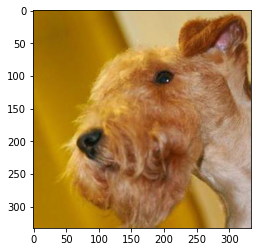

In [9]:
# SAMPLE KERAS

# img_path = 'elephant.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)


# on passe une image dans le réseau
path ="train" + "/" + os.listdir("train")[0] + "/" + os.listdir("train" + "/" +os.listdir("train")[0])[0]

img = Image.open(path)

plt.imshow(img)

In [10]:
# transformation en array
x = image.img_to_array(img)
x.shape

(333, 333, 3)

In [11]:
# on rajoute une dims, comme si l'image était dans un batch de une image
x = np.expand_dims(x, axis=0)
x.shape

(1, 333, 333, 3)

In [12]:
# preprocessing propre à vgg 16... change pas les dims mais les valeurs...
x = preprocess_input(x)
x.shape

(1, 333, 333, 3)

In [14]:
# prediction avec VGG
feat = model_convo.predict(x)

In [15]:
# il en ressort l'output de VGG, cad les 512 feat-maps au format 11*11
feat.shape

(1, 10, 10, 512)

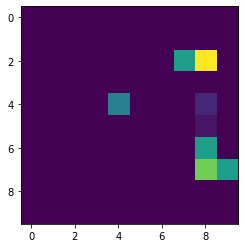

In [16]:
# affichage de la featmap[x]
plt.imshow(feat[0, :, :, 225])

## **Transfert Model-1**

In [66]:
# import vgg16 sans les couches denses
model_convo = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

In [67]:
# définition de la sortie du model convo
# on zappe la dernière couche de pooling qui rendrait des images trop petites

for layer in model_convo.layers :
    layer.trainable = False

In [68]:
# partie dense
# entrée
x = model_convo.layers[-1].output
# applatissement
x = Flatten()(x)
# couche Dense 120 sortie directe
preds = Dense(120, activation = "softmax")(x)

In [69]:
# Def du modèle totale
model_1 = Model(inputs = model_convo.input, outputs = preds)
model_1.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [71]:
BATCH = 32
SEED = 47
NB_TRAIN = 74137 # nb original
#NB_TRAIN_light = 4917 # nb original

TRAIN_STEPS = NB_TRAIN // BATCH
#TRAIN_STEPS_light = NB_TRAIN_light // BATCH

VAL_STEPS = TRAIN_STEPS // 5
#VAL_STEPS_light = TRAIN_STEPS_light // 5

print(TRAIN_STEPS, VAL_STEPS)

2316 463


In [72]:
train_gen_1, val_gen_1 = create_generator(BATCH, PATH_TRAIN, (224, 224))

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.


Epoch 1/10
2316/2316 [==============================] - 432s 185ms/step - loss: 6.3354 - accuracy: 0.1467 - val_loss: 3.0350 - val_accuracy: 0.4426
Epoch 2/10
2316/2316 [==============================] - 420s 181ms/step - loss: 2.5562 - accuracy: 0.5225 - val_loss: 2.0134 - val_accuracy: 0.6005
Epoch 3/10
2316/2316 [==============================] - 415s 179ms/step - loss: 1.5314 - accuracy: 0.6772 - val_loss: 1.6685 - val_accuracy: 0.6546
Epoch 4/10
2316/2316 [==============================] - 415s 179ms/step - loss: 0.9821 - accuracy: 0.7738 - val_loss: 1.2297 - val_accuracy: 0.7268
Epoch 5/10
2316/2316 [==============================] - 418s 180ms/step - loss: 0.6402 - accuracy: 0.8399 - val_loss: 1.0400 - val_accuracy: 0.7634
Epoch 6/10
2316/2316 [==============================] - 422s 182ms/step - loss: 0.4415 - accuracy: 0.8848 - val_loss: 1.1219 - val_accuracy: 0.7665
Epoch 7/10
2316/2316 [==============================] - 416s 179ms/step - loss: 0.3127 - accuracy: 0.9156 - val_

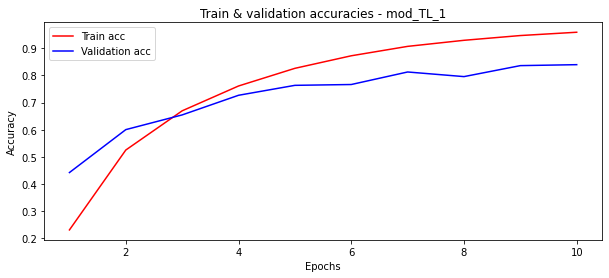

In [73]:
modelize(model_1, 10, train_gen_1, val_gen_1,  TRAIN_STEPS, VAL_STEPS, "mod_TL_1", 1)

## **Transfert Model-2**<br>
Deux couches denses

In [74]:
# partie dense
# entrée
x = model_convo.layers[-1].output
# applatissement
x = Flatten()(x)
# dense 120 avec RelU
x = Dense(120, activation = "relu")(x)
# dropout
# x = Dropout(0.1)(x)
# couche Dense 120 sortie
preds = Dense(120, activation = "softmax")(x)

In [75]:
model_2 = Model(inputs = model_convo.input, outputs = preds)
model_2.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [77]:
train_gen_1, val_gen_1 = create_generator(BATCH, PATH_TRAIN, (224, 224))
modelize(model_2, 5, train_gen_1, val_gen_1,  TRAIN_STEPS, VAL_STEPS, "mod_TL_2", 1)

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/5
2316/2316 [==============================] - 434s 187ms/step - loss: 4.8766 - accuracy: 0.0099 - val_loss: 4.7786 - val_accuracy: 0.0121
Epoch 2/5
 732/2316 [========>.....................] - ETA: 2:47 - loss: 4.7823 - accuracy: 0.0115

KeyboardInterrupt: ignored